In [1]:
import urllib
from IPython.display import Markdown as md

### change to reflect your notebook
_nb_loc = "11_adv_problems/11a_counting.ipynb"
_nb_title = "밀도를 근거로 객체 수를 세기"
_nb_message = """
이 노트북은 밀도를 기반으로 이미지의 객체 수를 세는 법을 보여준다.
이 방법에서는 개체를 정확히 식별하지 않아도 된다.
"""
### no need to change any of this
_icons=["https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book/master/logo-cloud.png", "https://www.tensorflow.org/images/colab_logo_32px.png", "https://www.tensorflow.org/images/GitHub-Mark-32px.png", "https://www.tensorflow.org/images/download_logo_32px.png"]
_links=["https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?" + urllib.parse.urlencode({"name": _nb_title, "download_url": "https://github.com/ychoi-kr/practical-ml-vision-book/raw/master/"+_nb_loc}), "https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://github.com/ychoi-kr/practical-ml-vision-book/blob/master/{0}".format(_nb_loc), "https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book/master/{0}".format(_nb_loc)]
md("""<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="{0}"><img src="{4}"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="{1}"><img src="{5}" />Run in Google Colab</a></td><td><a target="_blank" href="{2}"><img src="{6}" />View source on GitHub</a></td><td><a href="{3}"><img src="{7}" />Download notebook</a></td></table><br/><br/><h1>{8}</h1>{9}""".format(_links[0], _links[1], _links[2], _links[3], _icons[0], _icons[1], _icons[2], _icons[3], _nb_title, _nb_message))

<table class="tfo-notebook-buttons" align="left"><td><a target="_blank" href="https://console.cloud.google.com/ai-platform/notebooks/deploy-notebook?name=%EB%B0%80%EB%8F%84%EB%A5%BC+%EA%B7%BC%EA%B1%B0%EB%A1%9C+%EA%B0%9D%EC%B2%B4+%EC%88%98%EB%A5%BC+%EC%84%B8%EA%B8%B0&download_url=https%3A%2F%2Fgithub.com%2Fychoi-kr%2Fpractical-ml-vision-book%2Fraw%2Fmaster%2F11_adv_problems%2F11a_counting.ipynb"><img src="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book/master/logo-cloud.png"/>Run in AI Platform Notebook</a></td><td><a target="_blank" href="https://colab.research.google.com/github/ychoi-kr/practical-ml-vision-book/blob/master/11_adv_problems/11a_counting.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a></td><td><a target="_blank" href="https://github.com/ychoi-kr/practical-ml-vision-book/blob/master/11_adv_problems/11a_counting.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td><td><a href="https://raw.githubusercontent.com/ychoi-kr/practical-ml-vision-book/master/11_adv_problems/11a_counting.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a></td></table><br/><br/><h1>밀도를 근거로 객체 수를 세기</h1>
이 노트북은 밀도를 기반으로 이미지의 객체 수를 세는 법을 보여준다.
이 방법에서는 개체를 정확히 식별하지 않아도 된다.


## GPU 활성화
이 저장소의 노트북들은 GPU를 사용하면 더 빨리 실행된다.

코랩에서:
* 수정 → 노트 설정 메뉴로 이동
* 하드웨어 가속기 드롭다운에서 GPU를 선택

Cloud AI Platform Notebooks에서:
* https://console.cloud.google.com/ai-platform/notebooks 로 이동
* GPU를 포함한 인스턴스를 생성하거나, 인스턴스를 선택하고 GPU를 추가

다음으로, 텐서플로로 GPU에 연결할 수 있는지 확인.

In [2]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


## 이미지 및 패치 생성 함수

<ipython-input-3-34bd15c6b34d>:31: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = draw.circle(berry_cx[idx], berry_cy[idx],


70 berries simulated


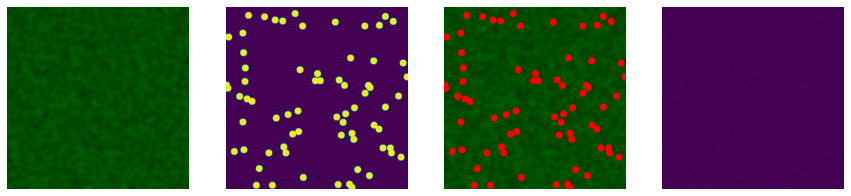

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import scipy.ndimage as ndimage
from skimage import draw

FULL_IMG_WIDTH = 512
FULL_IMG_HEIGHT = 512
IMG_CHANNELS = 3
PATCH_WIDTH = 32
PATCH_HEIGHT = 32
INPUT_WIDTH = PATCH_WIDTH*2
INPUT_HEIGHT = PATCH_HEIGHT*2

def generate_image(with_intermediates=False):
  # 이미지에는 무작위의 부드러운 녹색 배경이 있음
  backgr = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH, IMG_CHANNELS])
  backgr[ np.random.rand(FULL_IMG_HEIGHT, FULL_IMG_WIDTH) < 0.3, 1 ] = 1
  backgr = ndimage.gaussian_filter(backgr, sigma=(5, 5, 0), order=0)

  # 25~75개의 열매를 무작위로 배치
  num_berries = np.random.randint(25, 75)
  berry_cx = np.random.randint(0, FULL_IMG_WIDTH, size=num_berries)
  berry_cy = np.random.randint(0, FULL_IMG_HEIGHT, size=num_berries)
  label = np.zeros([FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
  label[berry_cx, berry_cy] = 1

  # 지름이 10픽셀인 열매를 그림
  berries = np.zeros([FULL_IMG_HEIGHT, FULL_IMG_WIDTH])
  for idx in range(len(berry_cx)):
    rr, cc = draw.circle(berry_cx[idx], berry_cy[idx],
                         radius=10, 
                         shape=berries.shape)
    berries[rr, cc] = 1

  # 배경에 열매를 추가
  img = np.copy(backgr)
  img[berries > 0] = [1, 0, 0] # 빨강

  if with_intermediates:
    print("{} berries simulated".format(num_berries))
    return backgr, berries, img, label
  else:
    return img, label

images = generate_image(True)
f, ax = plt.subplots(1, len(images), figsize=(15, 5))
for idx, img in enumerate(images):
  ax[idx].imshow(img)
  ax[idx].axis('off')

In [4]:
## 이미지의 패치(조각)들을 반환
def get_patches(img, label, verbose=False):
  img = tf.expand_dims(img, axis=0)
  label = tf.expand_dims(tf.expand_dims(label, axis=0), axis=-1)
  if verbose:
    print(img.shape, label.shape)
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  patches = tf.image.extract_patches(img, 
                                     sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                                     strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                     rates=[1, 1, 1, 1],
                                     padding='SAME',
                                     name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  labels = tf.image.extract_patches(label,
                                    sizes=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                                    rates=[1, 1, 1, 1],
                                    padding='VALID',
                                    name='get_labels')
  labels = tf.reshape(labels, [num_patches, -1])
  # the "density" is the number of points in the label patch
  patch_labels = tf.math.reduce_sum(labels, axis=[1], name='calc_density')
  if verbose:
    print(patches.shape, labels.shape, patch_labels.shape)
  return patches, patch_labels

## 회귀 모델을 훈련해 밀도를 예측

In [5]:
# Getting input data
def create_dataset(num_full_images):
  def generate_patches():
    for i in range(num_full_images):
      img, label = generate_image()
      patches, patch_labels = get_patches(img, label)
      # print(len(patches) * num_full_images)
      for patch, patch_label in zip(patches, patch_labels):
        yield patch, patch_label

  return tf.data.Dataset.from_generator(
    generate_patches,
    (tf.float32, tf.float32), # patch, patch_label
    (tf.TensorShape([INPUT_HEIGHT*INPUT_WIDTH*IMG_CHANNELS]),
    tf.TensorShape([]))  
  )

trainds = create_dataset(1) # 이미지당 256개의 패치를 생성
for img, label in trainds.take(3):
  avg = tf.math.reduce_mean(img) # 이미지의 평균 픽셀
  print(img.shape, label.numpy(), avg.numpy())

(12288,) 0.0 0.06320177
(12288,) 0.0 0.09640203
(12288,) 1.0 0.109266944


<ipython-input-3-34bd15c6b34d>:31: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = draw.circle(berry_cx[idx], berry_cy[idx],


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 64, 64, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        3

<ipython-input-3-34bd15c6b34d>:31: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = draw.circle(berry_cx[idx], berry_cy[idx],


1600/1600 [==============================] - 97s 56ms/step - loss: 0.0103 - mse: 0.0103 - mae: 0.0346 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0174
Epoch 2/5
1600/1600 [==============================] - 84s 53ms/step - loss: 0.0049 - mse: 0.0049 - mae: 0.0234 - val_loss: 0.0040 - val_mse: 0.0040 - val_mae: 0.0188
Epoch 3/5
1600/1600 [==============================] - 87s 54ms/step - loss: 0.0032 - mse: 0.0032 - mae: 0.0185 - val_loss: 0.0015 - val_mse: 0.0015 - val_mae: 0.0116
Epoch 4/5
1600/1600 [==============================] - 74s 46ms/step - loss: 0.0030 - mse: 0.0030 - mae: 0.0169 - val_loss: 0.0026 - val_mse: 0.0026 - val_mae: 0.0171
Epoch 5/5
1600/1600 [==============================] - 73s 45ms/step - loss: 0.0029 - mse: 0.0029 - mae: 0.0165 - val_loss: 0.0023 - val_mse: 0.0023 - val_mae: 0.0163


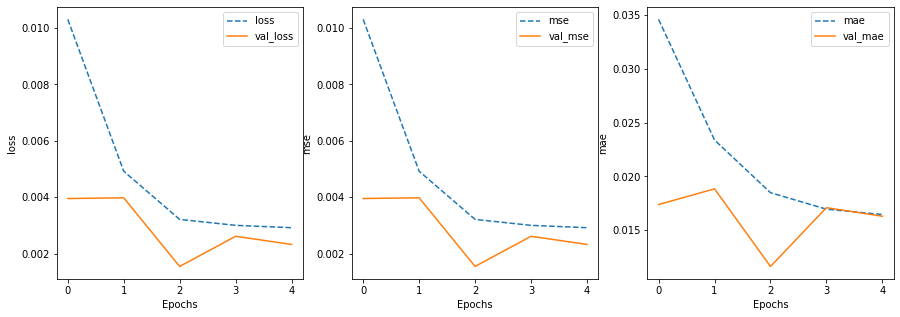

In [6]:
# 훈련
NUM_TRAIN = 200 # 10000으로 하면 더 현실적임
NUM_EVAL = 10 # 1000으로 하면 더 현실적임
NUM_EPOCHS = 5

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

def train_and_evaluate(batch_size = 32,
                       lrate = 0.001, # Adam constructor 기본값
                       l1 = 0,
                       l2 = 0,
                       num_filters = 32):
  regularizer = tf.keras.regularizers.l1_l2(l1, l2)
  train_dataset = create_dataset(NUM_TRAIN).batch(batch_size)
  eval_dataset = create_dataset(NUM_EVAL).batch(64)

  # 단순한 convnet임. 더 복잡하게 만들어도 됨.
  # 패턴이 평탄화되어 있으므로 이미지로 리셰이핑
  model = tf.keras.Sequential([
              tf.keras.layers.Reshape([INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS],
                                      input_shape=[INPUT_WIDTH * INPUT_HEIGHT * IMG_CHANNELS]),
              tf.keras.layers.Conv2D(num_filters, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.MaxPooling2D((2, 2)),
              tf.keras.layers.Conv2D(num_filters*2, (3,3), activation='relu'),
              tf.keras.layers.Flatten(),
              tf.keras.layers.Dense(num_filters*2,
                                    kernel_regularizer=regularizer, 
                                    activation=tf.keras.activations.relu),
              tf.keras.layers.Dense(1, activation='linear')
  ])
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss=tf.keras.losses.mean_squared_error,
                  metrics=['mse', 'mae'])
  print(model.summary())
  history = model.fit(train_dataset, validation_data=eval_dataset, epochs=NUM_EPOCHS)
  training_plot(['loss', 'mse', 'mae'], history)
  return model

model = train_and_evaluate()

36 berries simulated
8/8 [==============================] - 0s 4ms/step


<ipython-input-3-34bd15c6b34d>:31: FutureWarning: `draw.circle` is deprecated in favor of `draw.disk`.`draw.circle` will be removed in version 0.19
  rr, cc = draw.circle(berry_cx[idx], berry_cy[idx],


32 berries simulated
8/8 [==============================] - 0s 4ms/step
26 berries simulated
8/8 [==============================] - 0s 3ms/step
27 berries simulated
8/8 [==============================] - 0s 4ms/step
54 berries simulated
8/8 [==============================] - 0s 4ms/step
45 berries simulated
8/8 [==============================] - 0s 4ms/step
62 berries simulated
8/8 [==============================] - 0s 4ms/step
45 berries simulated
8/8 [==============================] - 0s 4ms/step
35 berries simulated
8/8 [==============================] - 0s 3ms/step
41 berries simulated
8/8 [==============================] - 0s 4ms/step
39 berries simulated
8/8 [==============================] - 0s 3ms/step
54 berries simulated
8/8 [==============================] - 0s 4ms/step
54 berries simulated
8/8 [==============================] - 0s 4ms/step
62 berries simulated
8/8 [==============================] - 0s 3ms/step
45 berries simulated
8/8 [==============================] - 0s 3

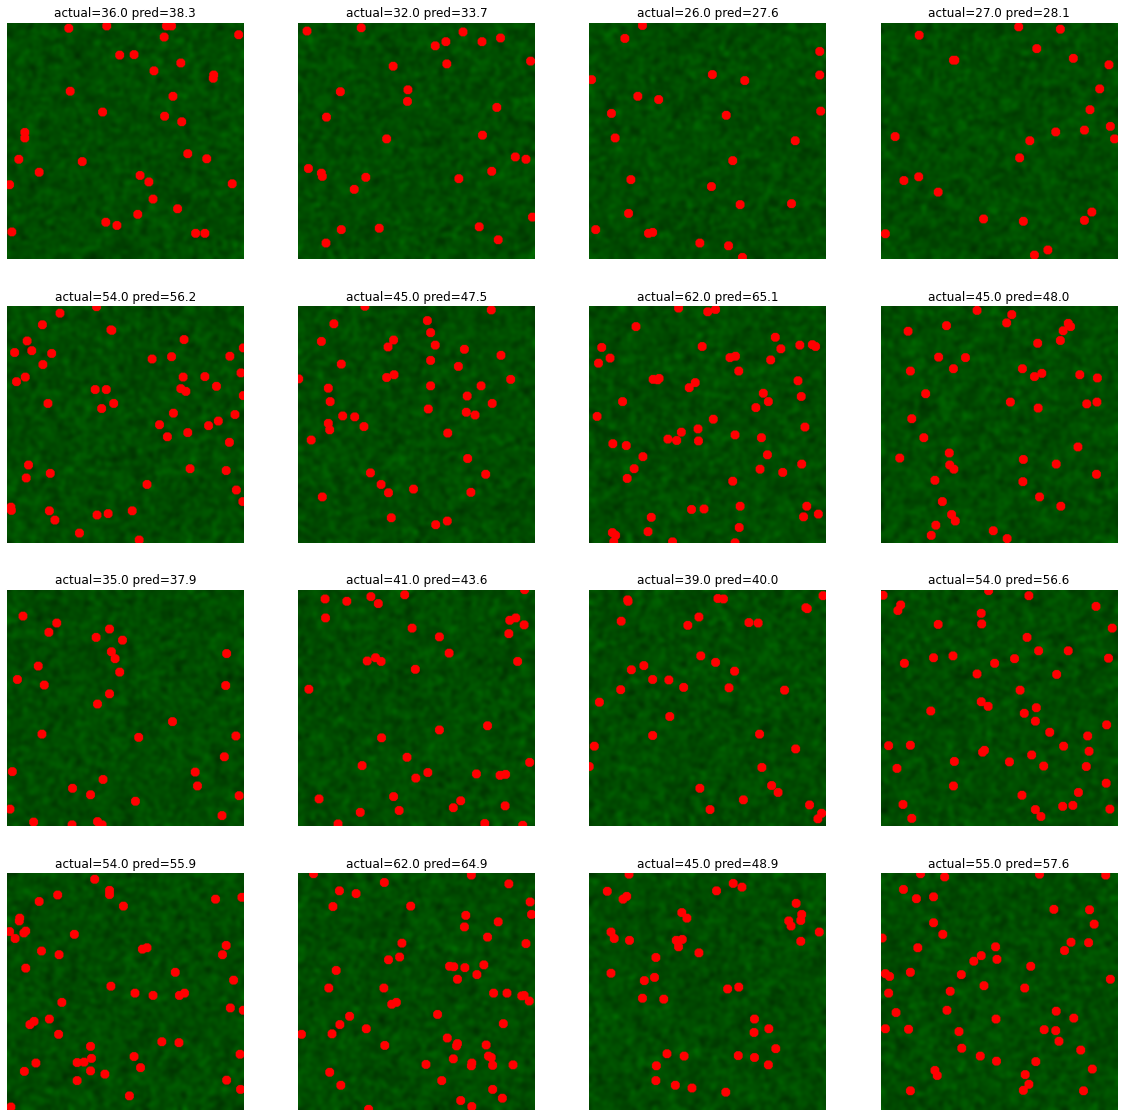

In [7]:
## 예측
def count_berries(model, img):
  num_patches = (FULL_IMG_HEIGHT // PATCH_HEIGHT)**2
  img = tf.expand_dims(img, axis=0)
  patches = tf.image.extract_patches(img,
                sizes=[1, INPUT_HEIGHT, INPUT_WIDTH, 1],
                strides=[1, PATCH_HEIGHT, PATCH_WIDTH, 1],
                rates=[1, 1, 1, 1],
                padding='SAME',
                name='get_patches')
  patches = tf.reshape(patches, [num_patches, -1])
  densities = model.predict(patches)
  return tf.reduce_sum(densities)

# 예제 이미지를 사용
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  backgr, berries, img, label = generate_image(True)
  ax[idx//4, idx%4].imshow(img)
  ax[idx//4, idx%4].set_title("actual={:.1f} pred={:.1f}".format(
    tf.reduce_sum(label).numpy(),
    count_berries(model, img).numpy()
  ))
  ax[idx//4, idx%4].axis('off')

## 책에 넣을 이미지

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: circle is deprecated in favor of disk.circle will be removed in version 0.19


(1, 512, 512, 3) (1, 512, 512, 1)
(256, 12288) (256, 1024) (256,)


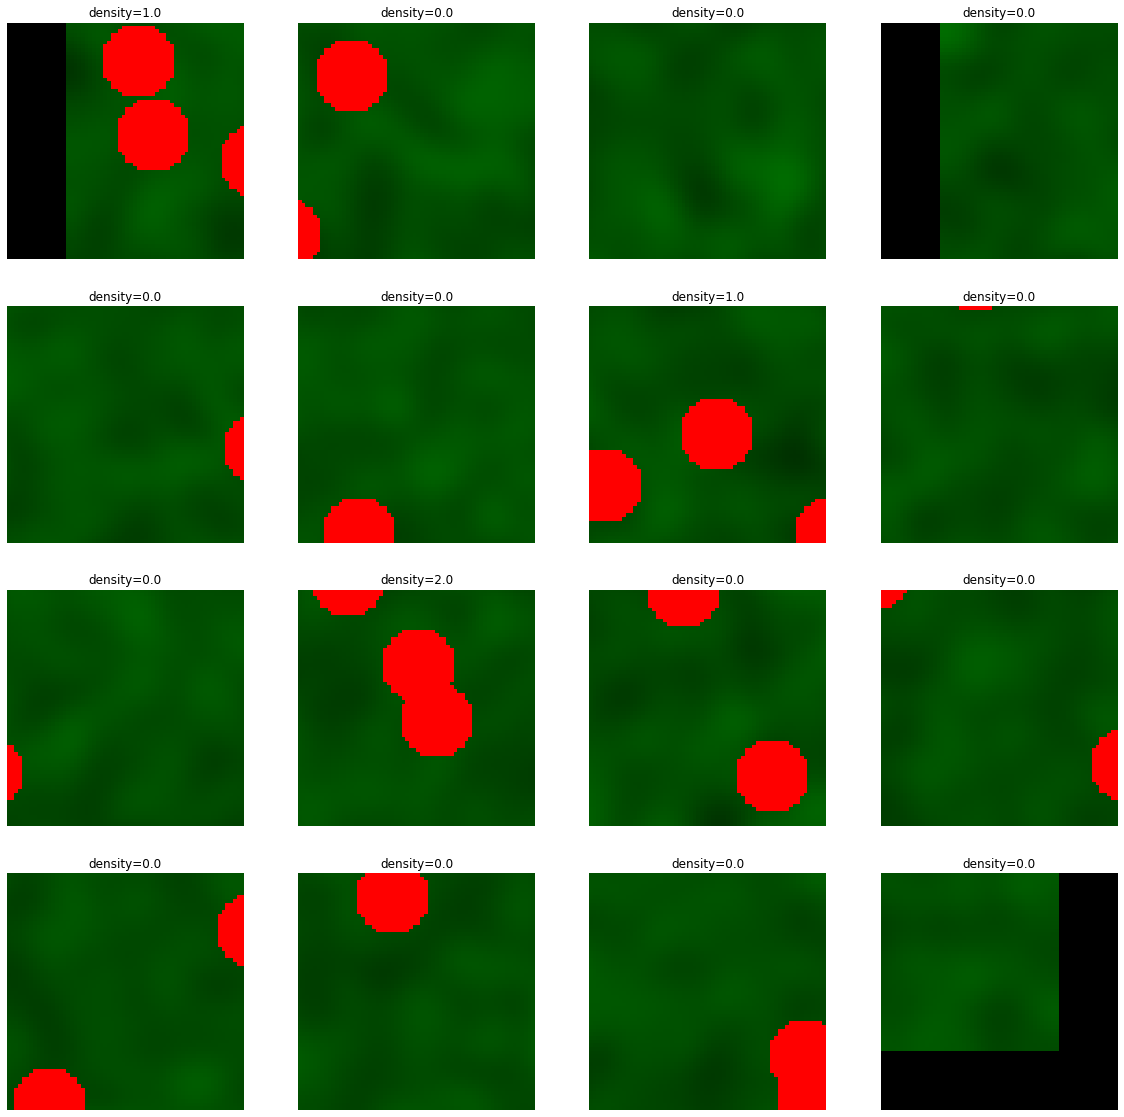

In [ ]:
# OPTIONAL, CAN BE OMITTED
img, label = images = generate_image()
patches, labels = get_patches(img, label, verbose=True)

# display a few patches
f, ax = plt.subplots(4, 4, figsize=(20, 20))
for idx in range(16):
  r = np.random.randint(0, patches.shape[0])
  ax[idx//4, idx%4].imshow(tf.reshape(patches[r], [INPUT_HEIGHT, INPUT_WIDTH, IMG_CHANNELS]).numpy())
  ax[idx//4, idx%4].set_title("density={:.1f}".format(labels[r].numpy()))
  ax[idx//4, idx%4].axis('off')

## 실제 이미지

실제 베리 이미지를 가지고 시도해보자

<img height="512" width="512" src="https://github.com/ychoi-kr/practical-ml-vision-book-ko/blob/master/11_adv_problems/berries.jpg?raw=1" />

In [ ]:
!file berries.jpg

berries.jpg: JPEG image data, JFIF standard 1.01, aspect ratio, density 72x72, segment length 16, Exif Standard: [TIFF image data, big-endian, direntries=2, orientation=upper-left], baseline, precision 8, 1531x1148, components 3


In [ ]:
contents = tf.io.read_file('./berries.jpg')
img = tf.image.decode_image(contents)
img = tf.image.resize(img, [FULL_IMG_WIDTH, FULL_IMG_HEIGHT])
n = count_berries(model, img)
print(n.numpy())

920.8319


실제 개수는 약 300이다. 결과가 3배로 나온 것은 실세계의 베리가 시뮬레이션한 베리보다 크기 때문일 것이다.
이는 시뮬레이션을 개선할 필요가 있음을 나타낸다. 베리 크기를 다르게 하면 좋을 것이다.

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.